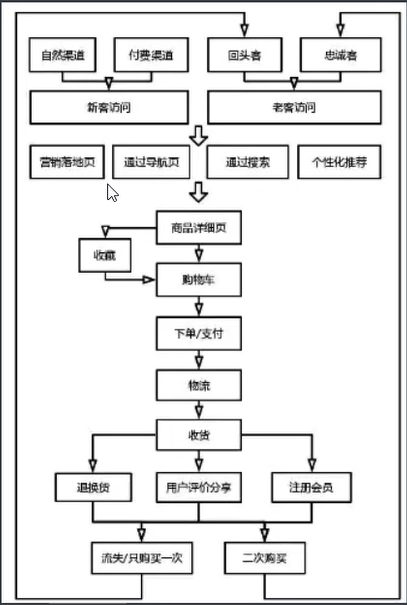

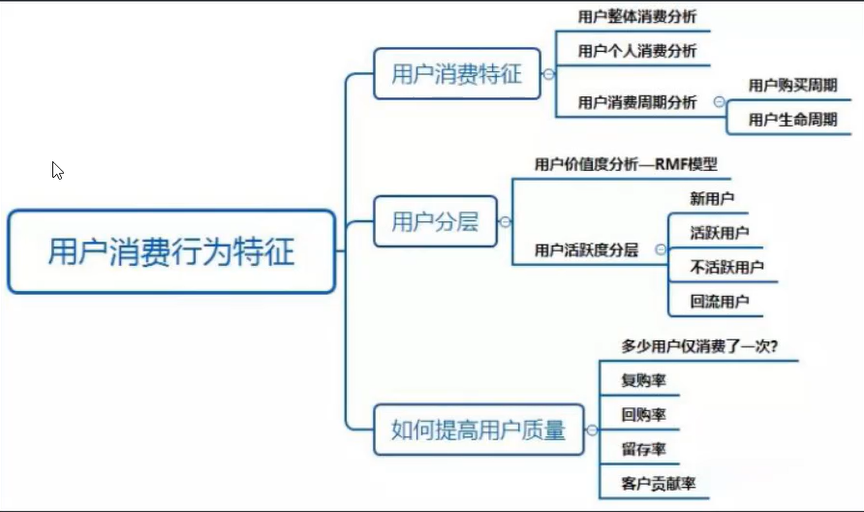

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

%matplotlib inline
plt.style.use('ggplot')    # 更改绘图风格， R语言绘图库的风格
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签

### 1、导入数据, 初步分析数据

In [2]:
# Load data
columns = ['user_id', 'order_dt', 'order_products', 'order_amount']
df = pd.read_table('data/CDNOW_master.txt', sep='\s+', names=columns)    # sep ='\s+'  匹配任意个空格
df.head()

# 1. 日期格式需要转换
# 2. 存在同一个用户一天内多次购买的行为

,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [3]:
df.describe()

# 1. 用户平均每笔订单购买2.4个商品, 标准差2.3, 稍微有点波动, 属于正常.
#   然而 75% 分位数的时候， 说明绝大多数订单的购买量都不多， 围绕在 2~3 个产品左右
# 2.购买金额，反映出大部分订单消费金额集中在中小额，30~45左右

,user_id,order_dt,order_products,order_amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         69659 non-null  int64  
 1   order_dt        69659 non-null  int64  
 2   order_products  69659 non-null  int64  
 3   order_amount    69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


### 2、数据预处理, 用户整体消费分析(按月)

In [5]:
df['order_date'] = pd.to_datetime(df['order_dt'], format='%Y%m%d')
# format 参数： 按照指定的格式去匹配要转换的数据列
# %Y: 四位的年份    %m: 两位月份    %d: 两位日期
# %y: 两位的年份    %h: 小时   %M: 分钟    %s: 两位 秒

# 将 order_date 转化成精度为月份的 PeriodIndex 对象
df['month'] = df['order_date'].dt.to_period('M')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         69659 non-null  int64         
 1   order_dt        69659 non-null  int64         
 2   order_products  69659 non-null  int64         
 3   order_amount    69659 non-null  float64       
 4   order_date      69659 non-null  datetime64[ns]
 5   month           69659 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int64(3), period[M](1)
memory usage: 3.2 MB


Text(0.5, 1.0, '每月的消费人数')

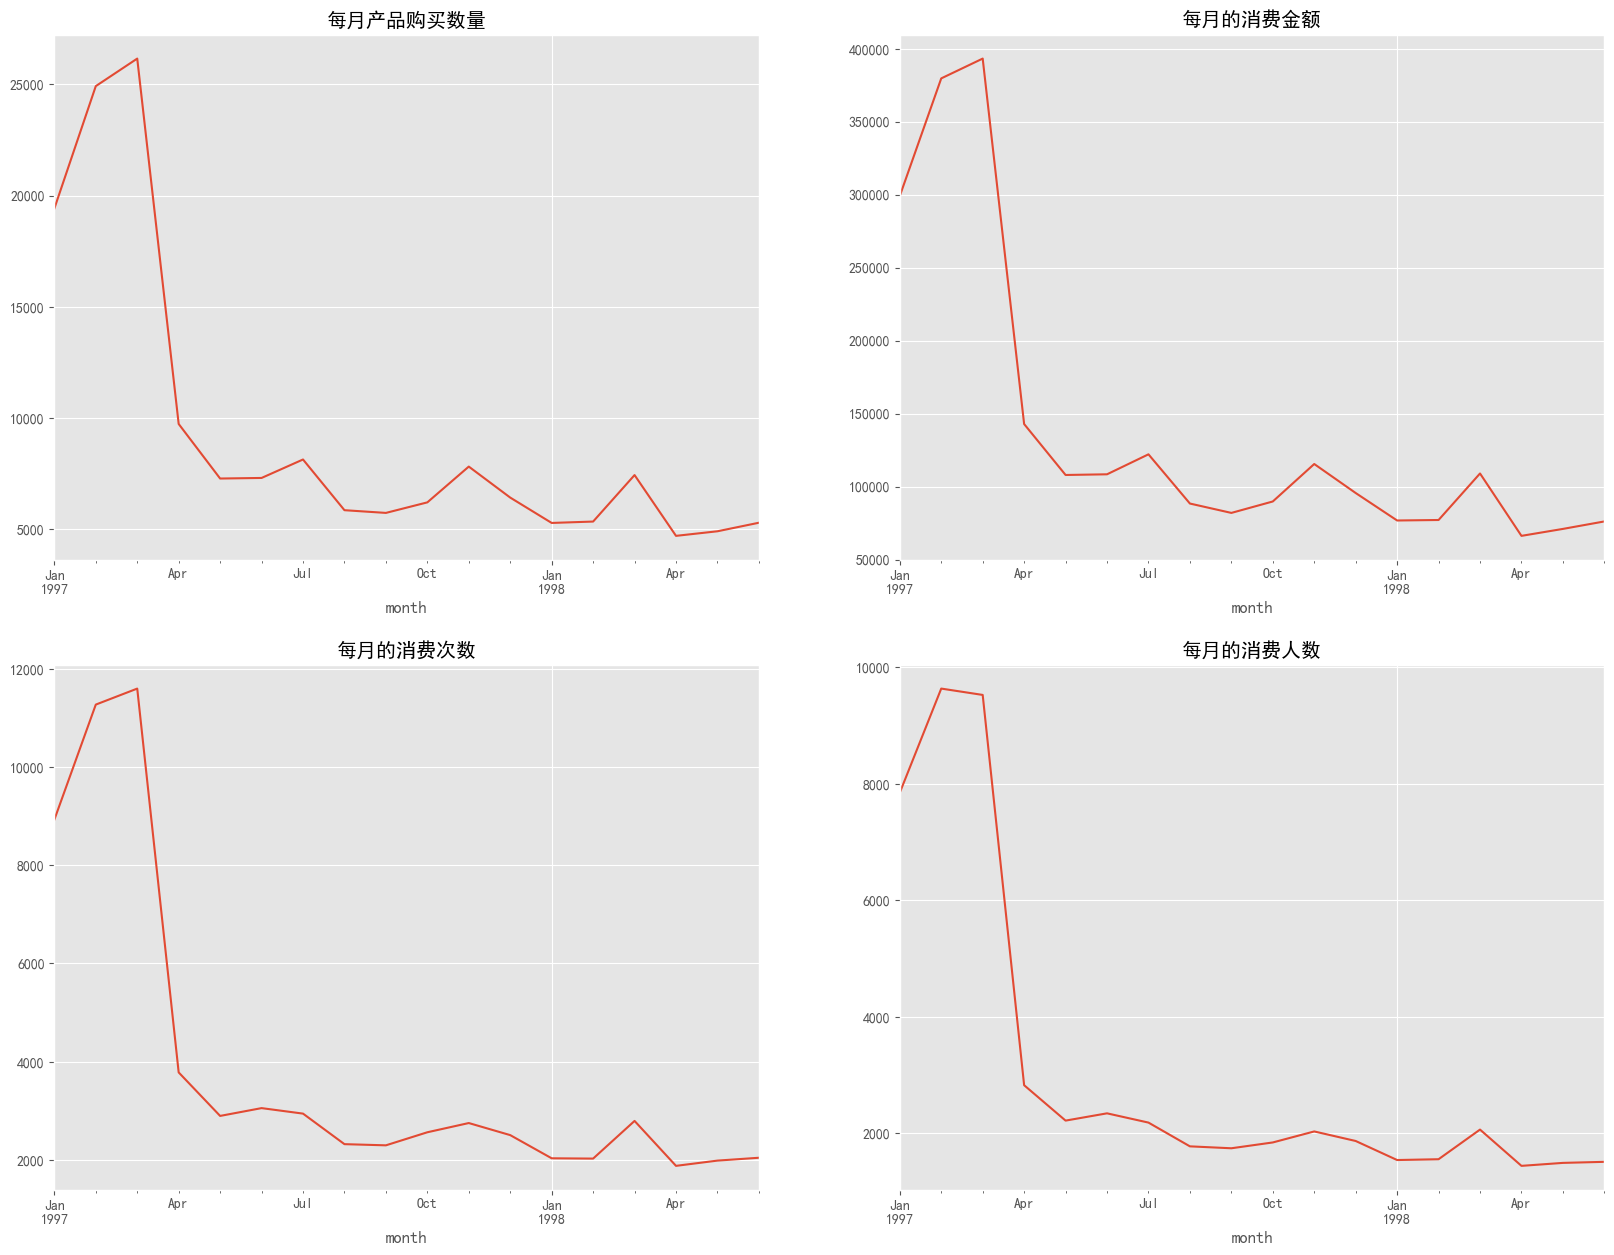

In [6]:
# 用户整体消费趋势分析 【按月份】
# 按月份统计 产品购买数量, 消费金额, 消费次数, 消费人数

plt.figure(figsize=(20, 15))    # 单位: 英寸

plt.subplot(221)    # 两行两列的第一个图
df.groupby('month')['order_products'].sum().plot()     # 默认折线图
plt.title('每月产品购买数量')

plt.subplot(222)    # 两行两列的第二个图
df.groupby('month')['order_amount'].sum().plot()     # 默认折线图
plt.title('每月的消费金额')

plt.subplot(223)    # 两行两列的第三个图
df.groupby('month')['user_id'].count().plot()     # 默认折线图
plt.title('每月的消费次数')

# 统计每月的消费人数 【根据user_id 进行去重统计, 再计算个数】
plt.subplot(224)    # 两行两列的第三个图
df.groupby('month')['user_id'].apply(lambda x:len(x.drop_duplicates())).plot()     # 默认折线图
plt.title('每月的消费人数')

# 分析结果：
# 图一 : 前 3 个月销量非常的高 [average 2.3W]， 而之后的销量较为稳定 [8K]， 并且稍微呈现下降的趋势
# 图二 : 前 3 个月消费金额较高, 与消费数量成正比例关系, 3月份过后下降严重， 并呈现下降趋势, 
    # 思考原因  1 : 跟月份有关, 在我国 1, 2, 3 月份处于春节前后。 
    #          2 : 公司在 1, 2, 3 月份的时候 是否加大了促销力度
# 图三 : 前三个月订单数在10000左右，后续月份的平均消费单数在2500左右
# 图四 : 前三个月消费人数在8000~10000左右，后续平均消费消费在2000不到的样子

# 总结 : 所有数据显示, 97年前3个月消费事态异常, 后续趋于常态化

### 3、 用户个体消费分析
    
    a. 用户消费金额，消费次数(产品数量)描述统计 

In [7]:
df = df[['user_id', 'order_dt', 'order_products', 'order_amount']]
user_group = df.groupby('user_id').sum()
print(user_group.describe())


# 从用户的角度: 用户数量23570个, 每个用户平均购买7个CD, 但是中位数只有3,
#              并且最大购买量为1033, 平均值大于中位数, 属于典型的右偏分布 [替购买量 < 7 的用户背锅 ]

# 从消费金额角度:平均用户消费106, 中位数43, 并且存在士豪用户13990, 结合分位数和最大值来看, 平均数与75%分位数几乎相等
#               属于典型的右偏分布，说明存在小部分用户(后面的25%)高额消费(这些用户需要给消费金额<106的用户背锅, 只有这样才能使平均数维持在106)              


           order_dt  order_products  order_amount
count  2.357000e+04    23570.000000  23570.000000
mean   5.902627e+07        7.122656    106.080426
std    9.460684e+07       16.983531    240.925195
min    1.997010e+07        1.000000      0.000000
25%    1.997021e+07        1.000000     19.970000
50%    1.997032e+07        3.000000     43.395000
75%    5.992125e+07        7.000000    106.475000
max    4.334408e+09     1033.000000  13990.930000


<Axes: xlabel='order_products', ylabel='order_amount'>

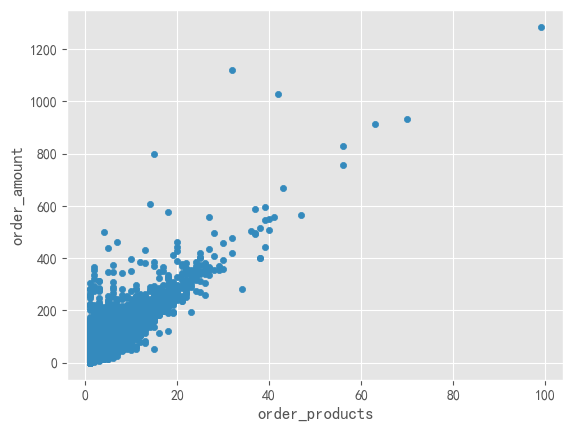

In [8]:
# 绘制每个用户的产品的购买最与消费金额散点图
df.plot(kind='scatter', x='order_products', y='order_amount')


# 从图中可知, 用户的消费金额与购买量呈现线性趋势, 每个商品均价15左右
# 订单的极值点比较少(消费金额 > 1000, 或者购买量大于60)，对于样本来说影响不大，可以忽略不记。


    b. 用户消费分布图

Text(0.5, 0, '每个user_id购买的数量')

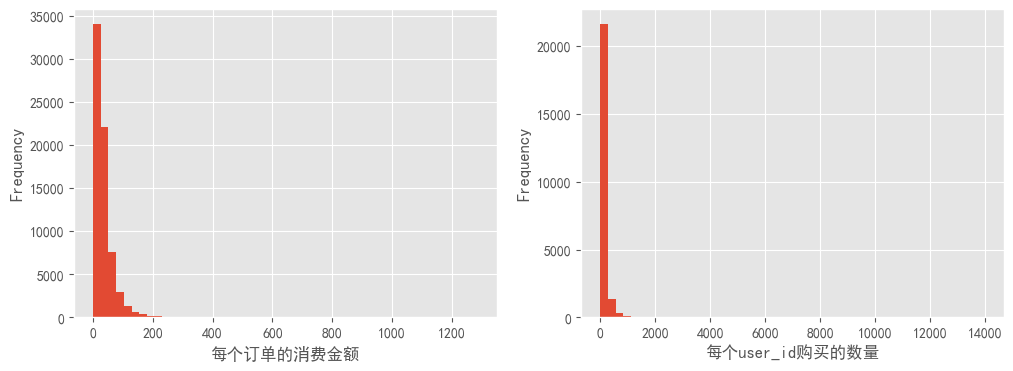

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(121)

df['order_amount'].plot(kind='hist', bins=50)   # bins : 区间分数， 影响柱子的宽度， 值越大， 柱子越细。 宽度=（列最大值-最小值）/bins
plt.xlabel('每个订单的消费金额')

# 消费金额在100以内的订单占据了绝大多数


plt.subplot(122)
df.groupby('user_id')['order_amount'].sum().plot(kind='hist', bins=50)
plt.xlabel('每个user_id购买的数量')

# 图二可知，每个用户购买数量非常小，集中在50以内
# 两幅图得知，我们的用户主要是消费金额低，并且购买小于50的用户人数占据大多数
#  [ 在电商领域是非常正常的现象 ]

    C. 用户累计消费金额占比分析(用户的贡献度)

In [10]:
#  用户分组, 获取消费金额,  求和,  排序, 重置索引
user_cumsum = df.groupby('user_id')['order_amount'].sum().sort_values().reset_index()
user_cumsum


,user_id,order_amount
0,10175,0.00
1,4559,0.00
2,1948,0.00
3,925,0.00
4,10798,0.00
...,...,...
23565,7931,6497.18
23566,19339,6552.70
23567,7983,6973.07
23568,14048,8976.33


In [13]:
# 每个用户消费金额累加
#   累加器举例:

# a = [1, 2, 3, 4, 5, 6, 7]   
# print(np.cumsum(a))             # cumsum: 累积总和

user_cumsum['amount_cumsum'] = user_cumsum['order_amount'].cumsum()
user_cumsum.tail()

,user_id,order_amount,amount_cumsum
23565,7931,6497.18,2463822.60
23566,19339,6552.70,2470375.30
23567,7983,6973.07,2477348.37
23568,14048,8976.33,2486324.70
23569,7592,13990.93,2500315.63


In [14]:

amount_total = user_cumsum['amount_cumsum'].max()    #  消费金额总值
user_cumsum['prop'] = user_cumsum.apply(lambda x:x['amount_cumsum']/amount_total, axis=1)    # 前  XX 用户的总贡献率
user_cumsum.tail()

,user_id,order_amount,amount_cumsum,prop
23565,7931,6497.18,2463822.60,0.985405
23566,19339,6552.70,2470375.30,0.988025
23567,7983,6973.07,2477348.37,0.990814
23568,14048,8976.33,2486324.70,0.994404
23569,7592,13990.93,2500315.63,1.000000


<Axes: >

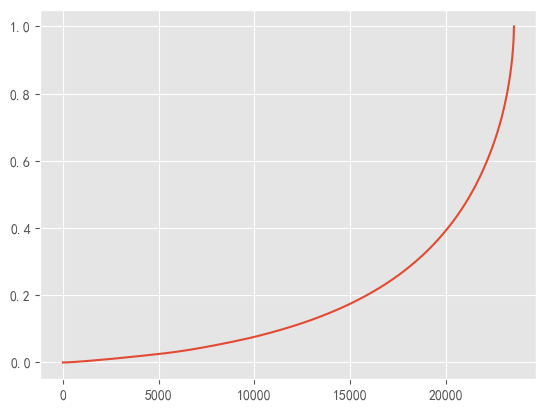

In [15]:
user_cumsum['prop'].plot()

# 由图分析可知,前20000名用户贡献总金额的40%, 剩余3500名用户贡献了60%。(2/8原则)